In [2]:
from typing import Dict, TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os
from pydantic import BaseModel

# Load environment variables and set OpenAI API key
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")

# Database Implementation

In [2]:
from sqlalchemy import create_engine, Column, Integer, String, Float, Date
from sqlalchemy.orm import declarative_base, sessionmaker, Session
import datetime

# import logging
# # Suppress SQLAlchemy logging output
# logging.basicConfig()
# logging.getLogger('sqlalchemy.engine').setLevel(logging.WARNING)

Base = declarative_base()

# create database
engine = create_engine('sqlite:///amar-shop.db', echo=False)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)

database = SessionLocal()

In [3]:
from db import Products, Services

# LangGraph Implementation

In [4]:
from typing import Annotated
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    query: str
    category: List[str]
    sentiment: str
    response: str

In [7]:
from langchain_core.tools import tool

class GetProductInput(BaseModel):
    product_type: str
    skip: int = 0
    limit: int = 10
    
    class Config:
        from_attributes = True 

@tool
def get_products_by_type(input_data: GetProductInput):
    """
    Fetches all products from the 'products' table that match the given product type.
    """
    # print(input_data)
    db = SessionLocal()
    products = db.query(Products).filter(Products.product_type.ilike(f"%{input_data.product_type}%")).offset(input_data.skip).limit(input_data.limit).all()

    product_list = [
        {
            "name": product.name,
            "price": product.price,
            "available_quantity": product.available_quantity,
            "expiry_date": product.expiry_date,
            "brand": product.brand,
        }
        for product in products
    ]
    
    return product_list

In [8]:
# import rich
# result = get_products_by_type(GetProductInput(product_type="Rice"))
# rich.print(result)

In [9]:
class GetServiceInput(BaseModel):
    name: str
    skip: int = 0
    limit: int = 10
    
    class Config:
        from_attributes = True 

def get_services(input_data: GetServiceInput):
    """
    Fetches all products from the 'products' table that match the given product type.
    """
    # print(input_data)
    db = SessionLocal()
    services = db.query(Services).filter(Services.name.ilike(f"%{input_data.name}%")).offset(input_data.skip).limit(input_data.limit).all()

    service_list = [
        {
            "name": service.name,
            "price": service.price,
        }
        for service in services
    ]
    
    return service_list

# get_services(GetServiceInput(name="Car Wash"))

[{'name': 'Car Wash', 'price': 20.0}]

In [12]:
def product_inquiry(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "You have access to the 'get_products_by_type' tool, which retrieves product data from the database based on the provided product type. "
        "When a user asks a query, first extract the relevant product type from the query. "
        "Then, use the 'get_products_by_type' tool to fetch the products that match the extracted product type. "
        "Finally, present the output to the user in a clear and concise manner as youre a sales man. Dont add unnecessary details. "
        "If no product type is found in the user's query, politely inform the user that the information is unavailable. "
        "User Query: {query}"
    )

    message_history = []
    llm = ChatOpenAI(model="gpt-4o")

    llm_with_tools = llm.bind_tools([get_products_by_type])
    chain = prompt | llm_with_tools

    message_history.append(HumanMessage(content=state["query"]))

    response = chain.invoke({"query": state["query"]})


    message_history.append(response)

    if response.tool_calls:
        tool_mapping = {
            "get_products_by_type": get_products_by_type
        }

        for tool_call in response.tool_calls:
            tool_name = tool_call["name"].lower()
            selected_tool = tool_mapping.get(tool_name)

            if selected_tool:
                tool_msg = selected_tool.invoke(tool_call)                
                message_history.append(tool_msg)
    final_response = chain.invoke({"query": message_history})

    return {"response": final_response.content}

query = "What are your rice products?"
result = product_inquiry(State(query=query))

NameError: name 'Products' is not defined

In [ ]:
result

In [10]:
def categorize(state: State) -> State:
    """Categorize the customer query into one of the predefined categories."""
    prompt = ChatPromptTemplate.from_template(
        "Classify the following customer query into one of these categories: "
        "product_inquiry (questions about products), "
        "service_inquiry (questions about services), "
        "chat (casual conversation), "
        "order_inquiry (questions about orders), "
        "pricing_inquiry (questions about prices and offers), "
        "profile_inquiry (questions about accounts or profiles), "
        "general_info (general information like store hours or policies). Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}



def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

IndentationError: unexpected indent (3372712987.py, line 32)

In [4]:
# Create the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

# Compile the graph
app = workflow.compile()

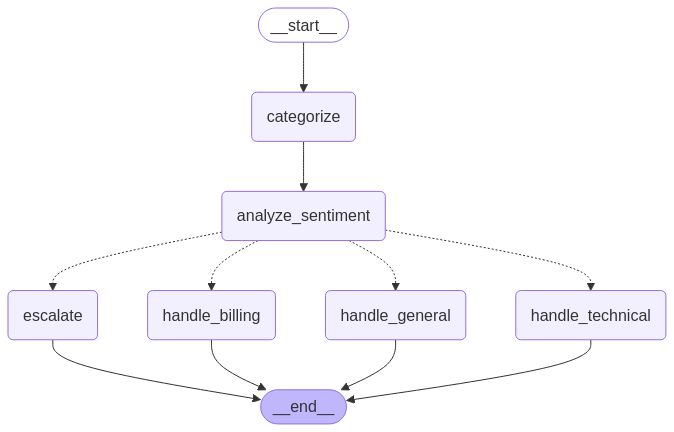

In [5]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [6]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.
    
    Args:
        query (str): The customer's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

In [7]:
# escalate
query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: My internet connection keeps dropping. Can you help?
Category: Technical
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.


In [8]:
# handle_technical
query = "I need help talking to chatGPT"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: I need help talking to chatGPT
Category: Technical
Sentiment: Neutral
Response: Hello,

Thank you for reaching out for technical support. To communicate with ChatGPT, you can simply start typing your message in the chatbox provided on the platform. ChatGPT is designed to respond to your messages in a conversational manner, so feel free to ask any questions or share any information you'd like.

If you are experiencing any specific issues while trying to communicate with ChatGPT, please provide more details so that we can assist you further. Thank you.


In [9]:
# handle_billing
query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: where can i find my receipt?
Category: Billing
Sentiment: Neutral
Response: Thank you for reaching out. To locate your receipt, please check your email inbox for a confirmation email from the time of purchase. You can also log into your account on our website and navigate to the "Order History" section to view and download your receipt. If you are unable to locate your receipt, please provide us with your order number or any other relevant information so we can assist you further. Thank you for your patience.


In [10]:
# handle_general
query = "What are your business hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")

Query: What are your business hours?
Category: General
Sentiment: Neutral
Response: Thank you for reaching out. Our business hours are [insert specific business hours here]. If you have any further questions or need assistance, please feel free to contact us during our operating hours.
